##Imports

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
import kaggle

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import keras
import tensorflow as tf
from keras import layers
from keras.preprocessing import image
from tensorflow import data as tf_data
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, MaxPooling2D, Dropout, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from tensorflow.keras.utils import to_categorical, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

##Global Variables

In [4]:
simple_model = False   #True: simple model, False: heavy model

##Loading the data

In [53]:
!kaggle competitions download -c dogs-vs-cats

100% 811M/812M [00:08<00:00, 276MB/s]
100% 812M/812M [00:08<00:00, 104MB/s]


In [54]:
!unzip -q dogs-vs-cats.zip

replace sampleSubmission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y


In [55]:
#!unzip -q test1.zip
!unzip -q train.zip

In [50]:
!rm dogs-vs-cats.zip
!rm test1.zip
!rm train.zip

rm: cannot remove 'test1.zip': No such file or directory
rm: cannot remove 'train.zip': No such file or directory


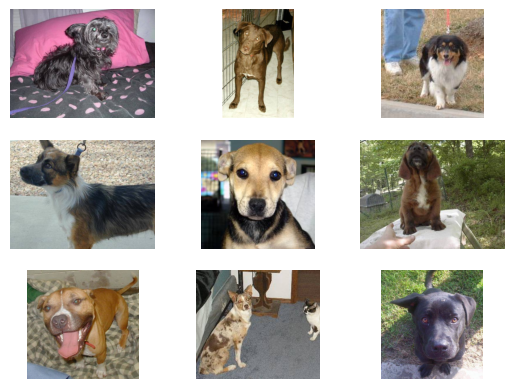

In [56]:
for i in range(9):
 plt.subplot(330 + 1 + i)
 filename = '/content/train/' + 'dog.' + str(i) + '.jpg'
 image = plt.imread(filename)
 plt.imshow(image)
 plt.axis('off')
plt.show()

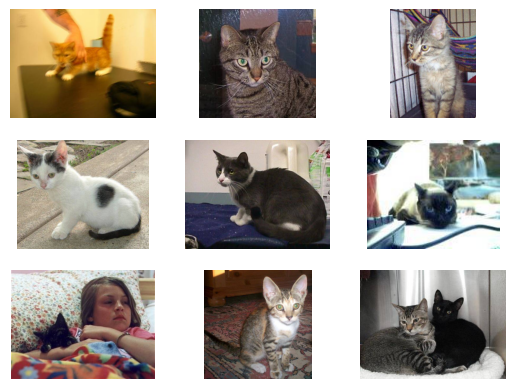

In [57]:
for i in range(9):
 plt.subplot(330 + 1 + i)
 filename = '/content/train/' + 'cat.' + str(i) + '.jpg'
 image = plt.imread(filename)
 plt.imshow(image)
 plt.axis('off')
plt.show()

In [59]:
!mkdir ./train/
!mkdir ./train/cat
!mkdir ./train/dog

In [60]:
!mkdir ./test/
!mkdir ./test/cat
!mkdir ./test/dog

mkdir: cannot create directory ‘./test/’: File exists
mkdir: cannot create directory ‘./test/cat’: File exists
mkdir: cannot create directory ‘./test/dog’: File exists


In [58]:
!mv ./train ./train_images


In [61]:
from random import seed, random
from shutil import move

seed(1)
val_ratio = 0.25

src_directory = './train_images/'
dst_train = './train/'
dst_test = './test/'

for file in os.listdir(src_directory):
    src = os.path.join(src_directory, file)

    # Check if the file is a regular file
    if os.path.isfile(src):
        dst_dir = dst_test if random() < val_ratio else dst_train

        if file.startswith('cat'):
            dst = os.path.join(dst_dir, 'cat', file)
            move(src, dst)
        elif file.startswith('dog'):
            dst = os.path.join(dst_dir, 'dog', file)
            move(src, dst)
    else:
        print(f"Warning: {src} is not a regular file. Skipping.")

##Data Generation

In [35]:
datatrain = ImageDataGenerator()
datatest = ImageDataGenerator()

In [36]:
train_data = datatrain.flow_from_directory('./train', target_size = (200, 200), classes = ["dog", "cat"], batch_size=64, class_mode='binary')

Found 18697 images belonging to 2 classes.


In [37]:
test_data = datatest.flow_from_directory('./test', target_size = (200,200), classes=["dog", "cat"], class_mode='binary')

Found 6303 images belonging to 2 classes.


##Building the models

In [38]:
if simple_model is True:
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(200,200,3)))
  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.5))
  model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.5))
  # taking the first row of the first slice of the volume and put it beside to the second row of the first slice, and so on
  model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(units = 1, activation = "sigmoid"))

else:
  model = Sequential()
  model.add(Conv2D(input_shape = (200,200,3), filters = 64, kernel_size = (3,3), padding = "same", activation = "relu"))
  model.add(Conv2D(filters = 64,kernel_size = (3,3),padding = "same", activation = "relu"))
  model.add(MaxPool2D(pool_size = (2,2),strides = (2,2)))
  model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = "same", activation = "relu"))
  model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = "same", activation = "relu"))
  model.add(MaxPool2D(pool_size = (2,2),strides = (2,2)))
  model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = "same", activation = "relu"))
  model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = "same", activation = "relu"))
  model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = "same", activation = "relu"))
  model.add(MaxPool2D(pool_size = (2,2),strides = (2,2)))
  model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
  model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
  model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
  model.add(MaxPool2D(pool_size = (2,2),strides = (2,2)))
  model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
  model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
  model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
  model.add(MaxPool2D(pool_size = (2,2),strides = (2,2)))
  model.add(Flatten())
  model.add(Dense(units = 4096,activation = "relu"))
  model.add(Dense(units = 4096,activation = "relu"))
  model.add(Dense(units = 1, activation = "sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 200, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 100, 100, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 100, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 100, 100, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 50, 50, 128)       0         
 g2D)                                                   

In [39]:
#Compile the model
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

##Training the model

In [40]:
#Train the model
history = model.fit(train_data, epochs=10, validation_data=test_data)

Epoch 1/10
293/293 [==============================] - 274s 821ms/step - loss: 0.6835 - accuracy: 0.5617 - val_loss: 0.6552 - val_accuracy: 0.6414
Epoch 2/10
293/293 [==============================] - 229s 782ms/step - loss: 0.6360 - accuracy: 0.6353 - val_loss: 0.6020 - val_accuracy: 0.6714
Epoch 3/10
293/293 [==============================] - 247s 842ms/step - loss: 0.5789 - accuracy: 0.6909 - val_loss: 0.5592 - val_accuracy: 0.7406
Epoch 4/10
293/293 [==============================] - 248s 845ms/step - loss: 0.5328 - accuracy: 0.7349 - val_loss: 0.6672 - val_accuracy: 0.6056
Epoch 5/10
293/293 [==============================] - 229s 780ms/step - loss: 0.4992 - accuracy: 0.7595 - val_loss: 0.4606 - val_accuracy: 0.7842
Epoch 6/10
293/293 [==============================] - 229s 783ms/step - loss: 0.4550 - accuracy: 0.7869 - val_loss: 0.4128 - val_accuracy: 0.8136
Epoch 7/10
293/293 [==============================] - 229s 783ms/step - loss: 0.4121 - accuracy: 0.8118 - val_loss: 0.3831 -

In [41]:
_, acc = model.evaluate(test_data)
print('Model accuracy:', acc)

197/197 [==============================] - 21s 107ms/step - loss: 0.3666 - accuracy: 0.8371
Model accuracy: 0.8370617032051086


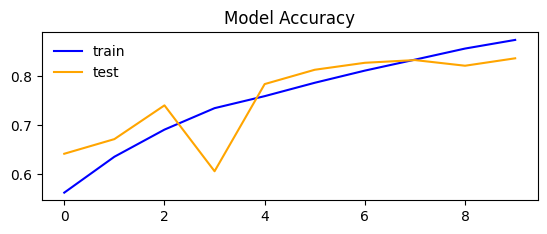

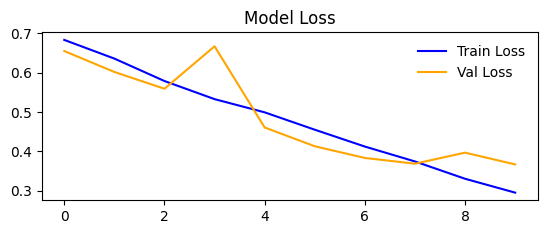

In [42]:
plt.subplot(211)
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='test')
plt.title('Model Accuracy')
plt.legend(frameon=False, loc='best')
plt.show()

plt.subplot(212)
plt.plot(history.history['loss'], color='blue', label='Train Loss')
plt.plot(history.history['val_loss'], color='orange', label='Val Loss')
plt.title('Model Loss')
plt.legend(frameon=False, loc='best')
plt.savefig("losses.jpg")
plt.show()

#Optimization of the model

In [43]:
checkPoint=ModelCheckpoint("cats_and_dogs_best_model.h5",
                           save_weights_only=False,
                           monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

earlyStopping=EarlyStopping(monitor='val_accuracy', min_delta = 0.001, patience=7, verbose=1, mode='max')

In [44]:
history2 = model.fit(train_data, validation_data=test_data, epochs=10, callbacks=[checkPoint, earlyStopping])

Epoch 1/10
293/293 [==============================] - ETA: 0s - loss: 0.2555 - accuracy: 0.8913
Epoch 1: val_accuracy improved from -inf to 0.85785, saving model to cats_and_dogs_best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


293/293 [==============================] - 230s 786ms/step - loss: 0.2555 - accuracy: 0.8913 - val_loss: 0.3322 - val_accuracy: 0.8578
Epoch 2/10
293/293 [==============================] - ETA: 0s - loss: 0.2236 - accuracy: 0.9063
Epoch 2: val_accuracy improved from 0.85785 to 0.89592, saving model to cats_and_dogs_best_model.h5
293/293 [==============================] - 234s 797ms/step - loss: 0.2236 - accuracy: 0.9063 - val_loss: 0.2502 - val_accuracy: 0.8959
Epoch 3/10
293/293 [==============================] - ETA: 0s - loss: 0.1926 - accuracy: 0.9199
Epoch 3: val_accuracy improved from 0.89592 to 0.90163, saving model to cats_and_dogs_best_model.h5
293/293 [==============================] - 233s 796ms/step - loss: 0.1926 - accuracy: 0.9199 - val_loss: 0.2413 - val_accuracy: 0.9016
Epoch 4/10
293/293 [==============================] - ETA: 0s - loss: 0.1678 - accuracy: 0.9315
Epoch 4: val_accuracy did not improve from 0.90163
293/293 [==============================] - 230s 784ms/st

In [45]:
_, acc = model.evaluate(test_data)
print('Model accuracy:', acc)

197/197 [==============================] - 21s 105ms/step - loss: 0.2798 - accuracy: 0.9089
Model accuracy: 0.9089322686195374


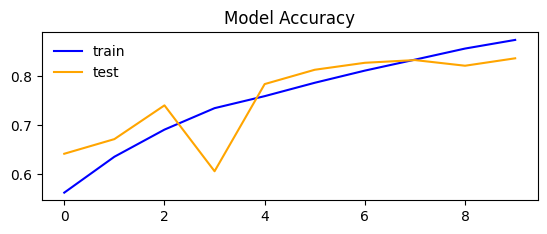

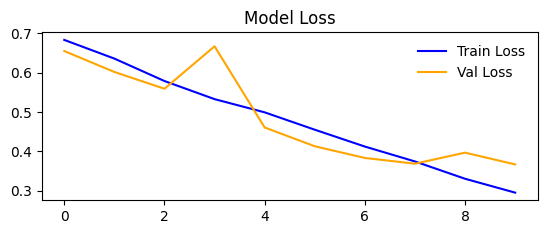

In [46]:
plt.subplot(211)
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='test')
plt.title('Model Accuracy')
plt.legend(frameon=False, loc='best')
plt.show()

plt.subplot(212)
plt.plot(history.history['loss'], color='blue', label='Train Loss')
plt.plot(history.history['val_loss'], color='orange', label='Val Loss')
plt.title('Model Loss')
plt.legend(frameon=False, loc='best')
plt.savefig("losses.jpg")
plt.show()

#Loading the model

In [62]:
best_model = load_model('./cats_and_dogs_best_model.h5')
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 200, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 100, 100, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 100, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 100, 100, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 50, 50, 128)       0         
 g2D)                                                   

In [63]:
best_model.evaluate(test_data)

197/197 [==============================] - 21s 107ms/step - loss: 0.2412 - accuracy: 0.9094


[0.24120260775089264, 0.9094082117080688]